# Brightfield Imaging: Quickstart

[![View on GitHub](https://img.shields.io/badge/View-on%20GitHub-lightgrey?logo=github)](https://github.com/Dana-Farber-AIOS/pathml/blob/master/examples/preprocessing_pipeline.ipynb)

In this notebook we will load a slide, set up a preprocessing pipeline, and run the pipeline.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from pathml.core import HESlide

%matplotlib inline

## Load the slide

In [3]:
wsi = HESlide("../data/CMU-1.svs", name = "example")

In [4]:
# How big is the slide at different levels (resolutions)?
for i in range(3):
    print(f"level {i}:\t{wsi.slide.get_image_shape(level = i)}")

level 0:	(32914, 46000)
level 1:	(8228, 11500)
level 2:	(2057, 2875)


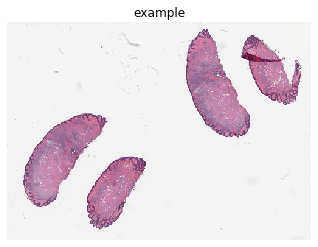

In [5]:
wsi.plot()

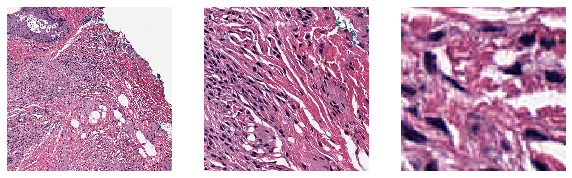

In [6]:
# Look at some specific regions
region0 = wsi.slide.extract_region(location = (8000, 32000), size = (2000, 2000))
region1 = wsi.slide.extract_region(location = (8500, 33000), size = (500, 500))
region2 = wsi.slide.extract_region(location = (8500, 33000), size = (100, 100))

fix, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 8))

ax[0].imshow(region0)
ax[1].imshow(region1)
ax[2].imshow(region2)

for a in ax: a.axis("off")
plt.show()

## Define the pipeline

First, let's define a simple preprocessing pipeline:

In [7]:
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE

pipeline = Pipeline([
    BoxBlur(kernel_size=15),
    TissueDetectionHE(mask_name = "tissue", min_region_size=500, 
                      threshold=30, outer_contours_only=True)
])

## Run the pipeline

Now that we have constructed our pipeline, we are ready to run it on our WSI.
PathML supports distributed computing, speeding up processing by running tiles in parallel among many workers rather than processing each tile sequentially on a single worker. 
This is supported by [Dask.distributed](https://distributed.dask.org/en/latest/index.html) on the backend, and is highly scalable for very large datasets. 
In this section, we will run the same pipeline using both `distributed=True` and `distributed=False` to see how this affects runtime.

### `distributed = False`

In [8]:
%%time
wsi.run(pipeline, distributed=False)

CPU times: user 32min 39s, sys: 5min 1s, total: 37min 40s
Wall time: 37min 29s


### `distributed = True`

The first step is to create a `client` object. In this case, we will use a simple cluster running locally; however, Dask supports other set-ups including Kubernetes, SLURM, Hadoop, etc. See the [PathML documentation](https://pathml.readthedocs.io/en/latest/running_pipelines.html#distributed-processing) for more information.

In [9]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=6)
client = Client(cluster)

print(client)

<Client: 'tcp://127.0.0.1:63468' processes=6 threads=12, memory=16.00 GiB>


Dask also provides an interactive dashboard which can be used to monitor the system in real-time. Simply navigate to the address:

In [10]:
client.dashboard_link

'http://127.0.0.1:8787/status'

In [11]:
# reload the WSI
wsi = HESlide("../data/CMU-1.svs", name = "example")

In [12]:
%%time
wsi.run(pipeline, distributed=True, client=client)

CPU times: user 7min 57s, sys: 54.5 s, total: 8min 51s
Wall time: 8min 20s


**By distributing our preprocessing among 6 workers, we reduced the runtime from 37 minutes to 8 minutes!**

Note that this example notebook was run on a consumer-grade laptop, which is why it only uses 6 workers - however, the PathML preprocessing API, powered by Dask, can scale up to many more than 6 workers, to take advantage of all available computational resources (e.g. cloud VMs, Kubernetes cluster, HPC cluster, etc.) to process large datasets of WSIs.
The scaling is not linear, as there is overhead incurred by orchestrating all the workers and sending data between them, but distributed computing is a very powerful way to see significant speed increases for running preprocessing!

## Look at the results

Let's take a look at some of the tiles, and the masks (i.e. regions of detected tissue):

In [13]:
print(f"Total number of tiles extracted: {len(wsi.tiles)}")

Total number of tiles extracted: 150


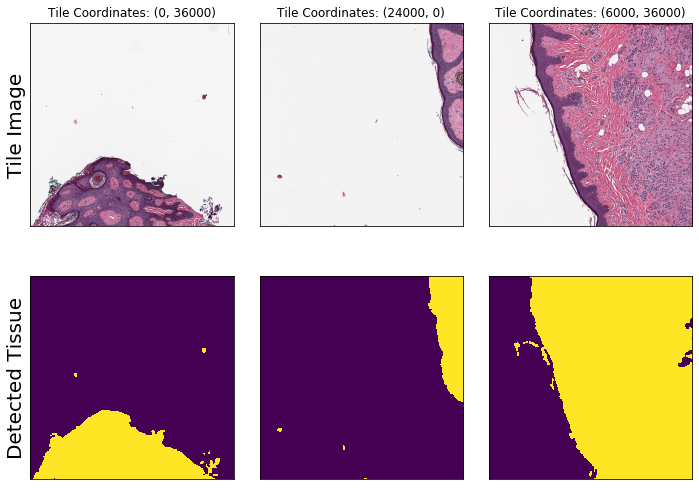

In [14]:
fix, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 7.5))

for c, tile_index in enumerate([10, 75, 130]):
    t = wsi.tiles[tile_index]
    ax[0, c].imshow(t.image.astype(np.uint8))
    ax[0, c].set_title(f"Tile Coordinates: {t.coords}")
    ax[1, c].imshow(t.masks["tissue"])

ax[0, 0].set_ylabel("Tile Image", fontsize = 20)
ax[1, 0].set_ylabel("Detected Tissue", fontsize = 20)
for a in ax.ravel(): 
    a.set_xticks([]); a.set_yticks([])
plt.tight_layout()
plt.show()

## Save preprocessed tiles

Now we can save the processed tiles to disk

In [15]:
wsi.write("mytiles.h5path")